In [228]:
#from pyprocessmacro import Process
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import numpy as np

dir = "C:/Users/foresight_User/Desktop/公司文件/4.CIT季賽/測試資料/"
data = pd.read_csv(dir+"CH_TO.csv").drop(columns=["Context Name"])
data.columns = list(map(lambda x: "x_" +str(x) ,range(len(data.columns)-1)))+["Y"]
feature = pd.read_csv(dir+"wb/Indicator_Data(1).csv").drop(columns=["Unnamed: 74","Context Name"])#.to_numpy()
target = pd.read_csv(dir+"wb/Metrology_Data(1).csv")[["Point1"]]#.to_numpy()


# data = pd.read_excel("C:/Users/foresight_User/Desktop/公司文件/4.CIT季賽/測試資料/Array7_N808測試資料集/Model_TJN808XK_SAMP75.xlsx").drop(columns=["CONTEXTID"])
# feature = data.drop(columns=list(filter(lambda x: "T2_CD" in x,data.columns)))#.to_numpy()
# target = data[["T2_CD01_Mean"]]#.to_numpy()


# data = pd.read_csv("C:/Users/foresight_User/Data/測試資料/VISERA_170.csv").drop(columns=["Context Name","Process Start Time","Metrology Start Time"])


# feature = data.drop(columns=['Point1', 'Point2', 'Point3', 'Point4', 'Point5', 'Point6', 'Point7',
#        'Point8', 'Point9', 'Point10', 'Point11', 'Point12', 'Point13',
#        'Point14', 'Point15', 'Point16', 'Point17', 'Point18', 'Point19',
#        'Point20', 'Point21', 'Point22', 'Point23', 'Point24', 'Point25',
#        'Point26', 'Point27', 'Point28', 'Point29', 'Point30', 'Point31',
#        'Point32', 'Point33', 'Point34', 'Point35', 'Point36', 'Point37',
#        'Point38', 'Point39', 'Point40', 'Point41', 'Point42', 'Point43',
#        'Point44', 'Point45', 'Point46', 'Point47', 'Point48', 'Point49'])

# target = data[['Point1', 'Point2', 'Point3', 'Point4', 'Point5', 'Point6', 'Point7',
#        'Point8', 'Point9', 'Point10', 'Point11', 'Point12', 'Point13',
#        'Point14', 'Point15', 'Point16', 'Point17', 'Point18', 'Point19',
#        'Point20', 'Point21', 'Point22', 'Point23', 'Point24', 'Point25',
#        'Point26', 'Point27', 'Point28', 'Point29', 'Point30', 'Point31',
#        'Point32', 'Point33', 'Point34', 'Point35', 'Point36', 'Point37',
#        'Point38', 'Point39', 'Point40', 'Point41', 'Point42', 'Point43',
#        'Point44', 'Point45', 'Point46', 'Point47', 'Point48', 'Point49']]





feature.columns = list(map(lambda x: "x_" +str(x) ,range(len(feature.columns))))
target.columns = list(map(lambda x: "y_" +str(x) ,range(len(target.columns))))
data = pd.concat([feature,target],axis=1)

In [229]:
experiment_0 =[]
experiment_1 = []
experiment_2 = []
experiment_3 = []


for i in range(100):
    #reg = RandomForestRegressor(n_estimators=100)
    reg = xgb.XGBRegressor(tree_method="hist", multi_strategy="multi_output_tree",random_state=np.random.randint(0,1000)) # one_output_per_tree
    X_train, X_test, y_train, y_test = train_test_split(
        feature, target, test_size=0.33,random_state=np.random.randint(0,1000))
    reg.fit(X_train, y_train)
    r2_score(y_test, reg.predict(X_test))


    from sdv.metadata import SingleTableMetadata

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data)


    # from sdv.single_table import GaussianCopulaSynthesizer
    # synthesizer = GaussianCopulaSynthesizer(
    #     metadata, # required
    #     enforce_min_max_values=True,
    #     enforce_rounding=False,
    #     #numerical_distributions={
    #         #'x_0': 'norm',
    #         #'x_1': 'beta',
    #         #'x_2': 'truncnorm',
    #         #'x_3': 'uniform',
    #         #'x_4': 'gamma',
    #         #'x_5': 'gaussian_kde'
    #     #},
    #     default_distribution='norm'
    # )
    from sdv.single_table import CTGANSynthesizer

    synthesizer = CTGANSynthesizer(
        metadata, # required
        enforce_rounding=False,
        epochs=500,
        verbose=True
    )


    
    synthesizer.fit(data)

    #synthetic_data = synthesizer.sample(num_rows=10)



    from sdv.sampling import Condition
    # condition_list = []
    # for y in data["y_0"].to_list():
    #     c = Condition(
    #         column_values={"y_0":y},
    #         num_rows=10
    #         )
    #     condition_list.append(c)
    condition_list = []
    for _, row in data.iterrows():
        y_values = {f"y_{i}": row[f"y_{i}"] for i in range(len(target.columns))}  # Adjust the range if you have more y columns
        c = Condition(column_values=y_values, num_rows=100)
        condition_list.append(c)


    synthetic_data = synthesizer.sample_from_conditions(
        conditions=condition_list,batch_size=50,max_tries_per_batch=500
    )


    X_unlabeled = synthetic_data.drop(columns=[f"y_{i}" for i in range(len(target.columns))]).to_numpy()
    y_unlabeled = synthetic_data[[f"y_{i}" for i in range(len(target.columns))]].to_numpy()
    
    ###
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
    initial_r2 = reg.score(X_test,y_test)



    #improvement_threshold = 0.01  # 設定提升R²的閾值
    selected_feature = np.empty((0, X_test.shape[1]))
    selected_target = np.empty((0, y_test.shape[1]))
    for i in range(len(X_unlabeled)):
        # 評估添加每個樣本後的R²變化
        candidate_feature = X_unlabeled[i].reshape(1, -1)
        candidate_target = y_unlabeled[i].reshape(1, -1)

        # 暫時增加樣本
        if selected_feature.size != 0 and selected_target.size != 0:
        #learner.teach(candidate_sample, candidate_label)
            X_new = np.vstack((X_test, candidate_feature,selected_feature))
            y_new = np.vstack((y_test, candidate_target,selected_target))
        else:
            X_new = np.vstack((X_test, candidate_feature))
            y_new = np.vstack((y_test, candidate_target))
        new_r2 = reg.score(X_new, y_new)
        # 檢查R²是否顯著提升
        if new_r2 > initial_r2:
            selected_feature = np.vstack((selected_feature, candidate_feature)) #np.append(selected_feature,candidate_feature).reshape(1, -1)
            selected_target  = np.vstack((selected_target, candidate_target)) #np.append(selected_target,candidate_target).reshape(1, -1)
            initial_r2 = new_r2  # 更新R²基準
            #print(initial_r2)
            
        # else:
        #     # #print("HHHHH",selected_samples)
        #     # # 如果沒有顯著提升，回退模型
        #     # learner = ActiveLearner(
        #     #     estimator=RandomForestRegressor(n_estimators=100),
        #     #     X_training=np.vstack((X_train.to_numpy(), X_unlabeled[selected_samples])),
        #     #     y_training=np.vstack((y_train.to_numpy(), y_unlabeled[selected_samples].reshape(-1,1)))
        #     # )

        # # 打印當前模型性能
        #print(f'Iteration {i+1}, New R²: {new_r2:.4f}')

    # 打印選擇的樣本索引
    #print("Selected samples that significantly improve R²:")
    #print(selected_samples)


    # 實驗 1
    fixed_model_origin_score = reg.score(X_test,y_test)
    fixed_model_selected_generative_data_score = reg.score(selected_feature,selected_target)

    

    experiment_0.append(fixed_model_origin_score)
    experiment_1.append(fixed_model_selected_generative_data_score)


    # 實驗 2
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_train_new = np.vstack((X_train,selected_feature))#.shape
    y_train_new = np.vstack((y_train,selected_target))
    reg2 = xgb.XGBRegressor(tree_method="hist", multi_strategy="multi_output_tree",random_state=np.random.randint(0,1000))
    reg2.fit(X_train_new, y_train_new)
    retrain_by_generative_data_without_test = reg2.score(X_test,y_test)
    experiment_2.append(retrain_by_generative_data_without_test)





    # 實驗3
    origin_X_train, origin_X_test, origin_y_train, origin_y_test = train_test_split(
        feature.to_numpy(), target.to_numpy(), test_size=0.33, random_state=np.random.randint(0,1000))
    generative_X_train, generative_X_test, generative_y_train, generative_y_test = train_test_split(
        selected_feature, selected_target, test_size=0.33, random_state=np.random.randint(0,1000))

    X_train = np.vstack((origin_X_train,generative_X_train))#.shape
    y_train = np.vstack((origin_y_train,generative_y_train))

    X_test = np.vstack((origin_X_test,generative_X_test))#.shape
    y_test = np.vstack((origin_y_test,generative_y_test))

    reg3 = xgb.XGBRegressor(tree_method="hist", multi_strategy="multi_output_tree",random_state=np.random.randint(0,1000))

    reg3.fit(X_train, y_train)
    retrain_resample_by_generative_data_all = reg3.score(X_test,y_test)
    retrain_resample_by_generative_data_IncludeOrigin = reg3.score(origin_X_test,origin_y_test)
    retrain_resample_by_generative_data_ExcludeOrigin = reg3.score(generative_X_test,generative_y_test)
    
    experiment_3.append([retrain_resample_by_generative_data_all,retrain_resample_by_generative_data_IncludeOrigin,retrain_resample_by_generative_data_ExcludeOrigin])

    #print(fixed_model_origin_score,fixed_model_selected_generative_data_score,retrain_by_generative_data_without_test,retrain_resample_by_generative_data)


Gen. (-2.19) | Discrim. (0.14): 100%|██████████| 500/500 [01:25<00:00,  5.85it/s] 
Sampling conditions: 100%|██████████| 72800/72800 [33:43<00:00, 35.98it/s]  
Gen. (-3.03) | Discrim. (-0.32): 100%|██████████| 500/500 [01:21<00:00,  6.13it/s]
Sampling conditions: 100%|██████████| 72800/72800 [38:29<00:00, 31.52it/s]
Gen. (-3.99) | Discrim. (0.00): 100%|██████████| 500/500 [01:21<00:00,  6.16it/s] 
Sampling conditions: 100%|██████████| 72800/72800 [39:23<00:00, 30.80it/s]  
Gen. (-1.15) | Discrim. (-0.14): 100%|██████████| 500/500 [01:22<00:00,  6.10it/s]
Sampling conditions: 100%|██████████| 72800/72800 [32:50<00:00, 36.94it/s]
Gen. (-3.27) | Discrim. (0.18): 100%|██████████| 500/500 [01:21<00:00,  6.15it/s] 
Sampling conditions: 100%|██████████| 72800/72800 [31:13<00:00, 38.85it/s] 
Gen. (-1.94) | Discrim. (0.18): 100%|██████████| 500/500 [01:22<00:00,  6.08it/s] 
Sampling conditions: 100%|██████████| 72800/72800 [39:32<00:00, 30.68it/s]
Gen. (-1.80) | Discrim. (-0.18): 100%|█████████

In [133]:
info = "&&&[model train by parts of real data]"
experiment_0_df = pd.DataFrame(experiment_0,columns=[f"origin_test_score{info}"]) # model train by train_data(real) vs test_data(real)

In [134]:
info = "&&&[model train by parts of real data]"
experiment_1_df = pd.DataFrame(experiment_1,columns=[f"generative_data_score{info}"]) # model train by train_data(real) vs test_data(generative data)

In [135]:
info = "&&&[model train by parts of real data but all generative data)]"
experiment_2_df = pd.DataFrame(experiment_2,columns=[f"origin_test_score{info}"]) # model train by train_data(real data + all generative data) vs test_data(real)

In [136]:
info = "&&&[model train ny parts of real data and parts of generative data)]"
experiment_3_df = pd.DataFrame(experiment_3,columns=[f"origin_test&generative_data_score{info}",f"origin_test_score{info}",f"generative_data_score{info}"]) 
# model train_data(real data + generative data) vs test_data(real data + generative data), test_data(real data), test_data(generative data)

In [137]:
experiment_data = pd.concat([experiment_0_df,experiment_1_df,experiment_2_df,experiment_3_df],axis=1)
#experiment_data_info = experiment_data["variable"].str.split("&&&",expand=True).rename(columns={0:"score",1:"training_info"})

In [138]:
experiment_data = pd.melt(experiment_data)

In [139]:
experiment_data_info = experiment_data["variable"].str.split("&&&",expand=True).rename(columns={0:"score",1:"training_info"})

In [140]:
experiment_data_info

,score,training_info
0,origin_test_score,[model train by parts of real data]
1,origin_test_score,[model train by parts of real data]
2,origin_test_score,[model train by parts of real data]
3,origin_test_score,[model train by parts of real data]
4,origin_test_score,[model train by parts of real data]
...,...,...
595,generative_data_score,[model train ny parts of real data and parts o...
596,generative_data_score,[model train ny parts of real data and parts o...
597,generative_data_score,[model train ny parts of real data and parts o...
598,generative_data_score,[model train ny parts of real data and parts o...


In [141]:
experiment_result = pd.concat([experiment_data,experiment_data_info],axis=1)

In [199]:
labels = ['[model train by parts of real data]',
'[model train by parts of real data but all generative data)]',
 '[model train ny parts of real data and parts of generative data)]']

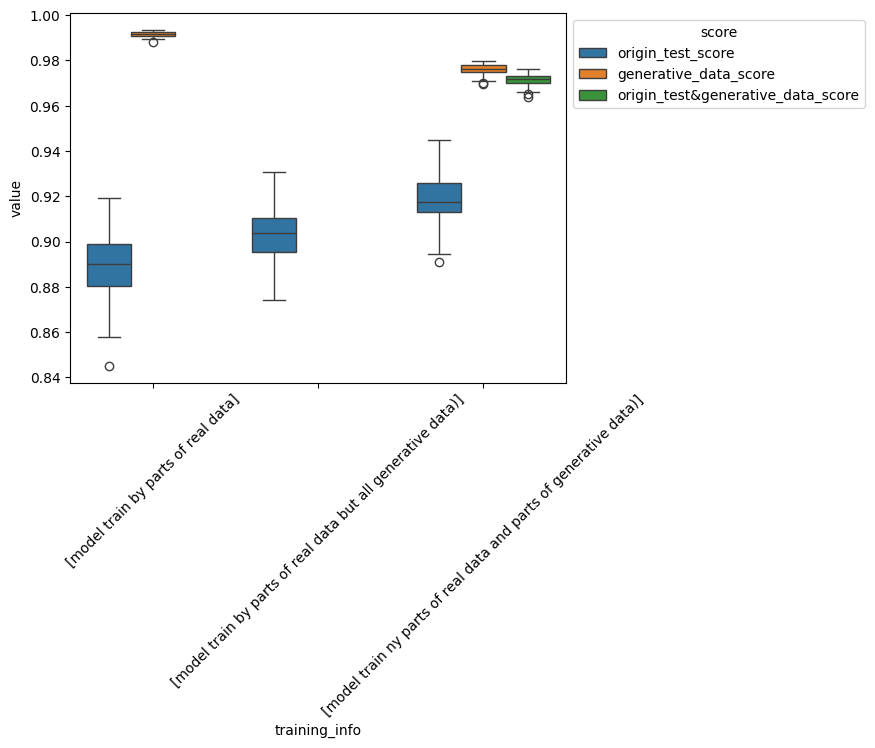

In [222]:
#experiment_result= pd.read_csv("C:/Users/foresight_User/Data/測試資料/VISERA_170_gerative_results.csv",sep="\t")
experiment_result= pd.read_csv("C:/Users/foresight_User/Desktop/公司文件/4.CIT季賽/測試資料/wb_gerative_results.csv",sep="\t")
import seaborn as sns
ax = sns.boxplot(data=experiment_result, x="training_info", y="value", hue="score")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=45)


In [95]:
#experiment_result.to_csv("C:/Users/foresight_User/Data/測試資料/VISERA_170_gerative_results.csv",sep="\t",index=False)

In [143]:
#experiment_result.to_csv("C:/Users/foresight_User/Desktop/公司文件/4.CIT季賽/測試資料/wb_gerative_results.csv",sep="\t",index=False)

In [144]:
#experiment_result.to_csv("C:/Users/foresight_User/Desktop/公司文件/4.CIT季賽/測試資料/Model_TJN808XK_SAMP75_gerative_results.csv",sep="\t",index=False)

In [215]:
set(experiment_result.score)

{'generative_data_score',
 'origin_test&generative_data_score',
 'origin_test_score'}

In [ ]:
# training_info
{'[model train by parts of real data but all generative data)]',
 '[model train by parts of real data]',
 '[model train ny parts of real data and parts of generative data)]'}

{'generative_data_score',
 'origin_test&generative_data_score',
 'origin_test_score'}

 
{'generative_data_score&&&[model train by parts of real data]',
 'generative_data_score&&&[model train ny parts of real data and parts of generative data)]',
 'origin_test&generative_data_score&&&[model train ny parts of real data and parts of generative data)]',
 'origin_test_score&&&[model train by parts of real data but all generative data)]',
 'origin_test_score&&&[model train by parts of real data]',
 'origin_test_score&&&[model train ny parts of real data and parts of generative data)]'}

In [223]:

pd.DataFrame(experiment_result.groupby(['variable','score','training_info'])["value"].median())

,,,value
variable,score,training_info,
generative_data_score&&&[model train by parts of real data],generative_data_score,[model train by parts of real data],0.991830
generative_data_score&&&[model train ny parts of real data and parts of generative data)],generative_data_score,[model train ny parts of real data and parts of generative data)],0.976308
origin_test&generative_data_score&&&[model train ny parts of real data and parts of generative data)],origin_test&generative_data_score,[model train ny parts of real data and parts of generative data)],0.971832
origin_test_score&&&[model train by parts of real data but all generative data)],origin_test_score,[model train by parts of real data but all generative data)],0.903953
origin_test_score&&&[model train by parts of real data],origin_test_score,[model train by parts of real data],0.890256
origin_test_score&&&[model train ny parts of real data and parts of generative data)],origin_test_score,[model train ny parts of real data and parts of generative data)],0.917300


In [178]:
from scipy.stats import ranksums

training_condition1 = (experiment_result.training_info == "[model train by parts of real data]")
training_condition2 = (experiment_result.training_info == "[model train by parts of real data but all generative data)]")
training_condition3 = (experiment_result.training_info == "[model train ny parts of real data and parts of generative data)]")

# training_condition1 = (experiment_result.training_info == "origin_test_score&&&[model train by parts of real data]")
# training_condition2 = (experiment_result.training_info == "[model train by parts of real data but all generative data)]")
# training_condition3 = (experiment_result.training_info == "[model train by parts of real data but all generative data)]")



score_condition = (experiment_result.score == "origin_test_score")



In [179]:
experiment_result[training_condition3 & score_condition]["value"]

400    0.054835
401    0.401097
402    0.351176
403   -0.301456
404    0.230266
         ...   
495    0.334662
496    0.012634
497    0.457470
498   -0.148225
499    0.239366
Name: value, Length: 100, dtype: float64

In [224]:
group1 = experiment_result[training_condition1 & score_condition]["value"]
group2 = experiment_result[training_condition2 & score_condition]["value"]
group3 = experiment_result[training_condition3 & score_condition]["value"]

In [225]:
stat, p_value = ranksums(group2,group1, alternative='greater')
p_value

6.554285325488133e-13

In [226]:
stat, p_value = ranksums(group3,group1, alternative='greater')
p_value

4.909012910117164e-31

In [227]:
stat, p_value = ranksums(group3,group2, alternative='greater')
p_value

6.09363431038222e-20